In [1]:
import pandas as pd


In [2]:
health_df = pd.read_csv("data/interim/health.csv")


In [3]:
# Extract metadata
abstracts = health_df["objective"].to_numpy()
titles = health_df["title"].to_numpy()


In [4]:
from sentence_transformers import SentenceTransformer

# Create an embedding for each abstract
embedding_model = SentenceTransformer("NovaSearch/stella_en_400M_v5", trust_remote_code=True)
embeddings = embedding_model.encode(abstracts, show_progress_bar=True)


Some weights of the model checkpoint at NovaSearch/stella_en_400M_v5 were not used when initializing NewModel: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing NewModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing NewModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Batches:   0%|          | 0/110 [00:00<?, ?it/s]

In [65]:
embeddings.shape


(3508, 1024)

In [63]:
from umap import UMAP

# We reduce the input embeddings from 384 dimensions to 5 dimensions
umap_model = UMAP(
    n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine', random_state=42
    )
reduced_embeddings = umap_model.fit_transform(embeddings)


In [72]:
from hdbscan import HDBSCAN

# We fit the model and extract the clusters
hdbscan_model = HDBSCAN(
    min_cluster_size=30, metric="euclidean", cluster_selection_method="eom"
).fit(reduced_embeddings)

clusters = hdbscan_model.labels_

# How many clusters did we generate?
len(set(clusters))


19

In [69]:
import numpy as np
# Print first three documents in cluster 0
cluster = 0

for index in np.where(clusters==cluster)[0][:3]:
    print(abstracts[index][:300] + "... \n")
    

Non-alcoholic fatty liver disease (NAFLD) has a global prevalence of nearly 25% i.e., affects one quarter of the adult population. Early phase NAFLD is reversible and can be treated, but it may progress towards life-threatening stages such as non-alcoholic steatohepatitis (NASH), cirrhosis, and hepa... 

Non-alcoholic fatty liver disease (NAFLD) is a multifactorial chronic inflammatory disease that is prevalent in 1 of 4 individuals with a significant personal, socioeconomic and healthcare burden, especially at the later, more severe inflammatory stage of disease - non-alcoholic steatohepatitis (NAS... 

The ARTEMIs project aims to consolidate existing computational mechanistic and machine-learning models at different scales to deliver virtual twins embedded in a clinical decision support system (CDSS).  The CDSS will provide clinically meaningful information to clinicians, for a more personalised m... 



(2436, 4)
(1072, 4)


(np.float64(2.3646576046943664),
 np.float64(11.670393025875091),
 np.float64(1.9950186491012574),
 np.float64(11.680376839637756))

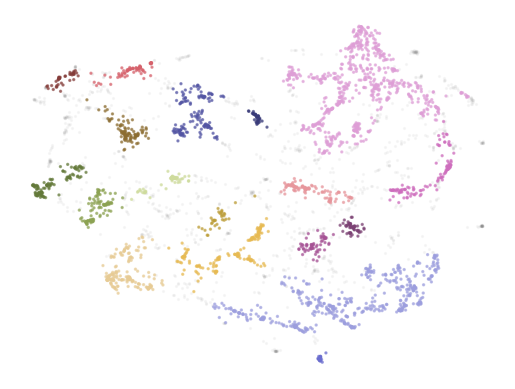

In [73]:
# Check clusters
import pandas as pd
import matplotlib.pyplot as plt

# Reduce 384-dimensional embeddings to two dimensions for easier visualization
reduced_embeddings = UMAP(
    n_components=2, min_dist=0.0, metric="cosine", random_state=42
).fit_transform(embeddings)

# Create dataframe
df = pd.DataFrame(reduced_embeddings, columns=["x", "y"])
df["title"] = titles
df["cluster"] = [str(c) for c in clusters]

# Select outliers and non-outliers (clusters)
to_plot = df.loc[df.cluster != "-1", :]
outliers = df.loc[df.cluster == "-1", :]

print(to_plot.shape)
print(outliers.shape)

# Plot outliers and non-outliers separately
plt.scatter(outliers.x, outliers.y, alpha=0.05, s=2, c="grey")
plt.scatter(to_plot.x, to_plot.y, c=to_plot.cluster.astype(int),
            alpha=0.6, s=2, cmap="tab20b"
)
plt.axis("off")


In [74]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer_model = CountVectorizer(stop_words="english", min_df=2, ngram_range=(1, 2))


In [75]:
from transformers import pipeline
from bertopic.representation import TextGeneration
from bertopic.representation import KeyBERTInspired, MaximalMarginalRelevance, OpenAI, PartOfSpeech

# KeyBERT
keybert_model = KeyBERTInspired()

# Part-of-Speech
pos_model = PartOfSpeech("en_core_web_sm")

# MMR
mmr_model = MaximalMarginalRelevance(diversity=0.3)

# Flan-t5
prompt = """
I have a topic that contains the following documents:
[DOCUMENTS]
The topic is described by the following keywords: [KEYWORDS]

Based on the information above, extract a short but highly descriptive topic label of at most 5 words. Make sure it is in the following format:
topic: <topic label>
"""
# Update our topic representations using Flan-T5
generator = pipeline("text2text-generation", model="google/flan-t5-small")
flant5_model = TextGeneration(
    generator, prompt=prompt, doc_length=350, tokenizer="whitespace"
)

# All representation models
representation_model = {
    "KeyBERT": keybert_model,
    "Flan-t5": flant5_model,
    "MMR": mmr_model,
    "POS": pos_model
}


Device set to use cuda:0


In [76]:
from bertopic import BERTopic

# Train our model with our previously defined models
# topic_model = BERTopic(
#     embedding_model=embedding_model,
#     umap_model=umap_model,
#     hdbscan_model=hdbscan_model,
#     verbose=True
# ).fit(abstracts, embeddings)

topic_model = BERTopic(
  # Pipeline models
  embedding_model=embedding_model,
  umap_model=umap_model,
  hdbscan_model=hdbscan_model,
  vectorizer_model=vectorizer_model,
  representation_model=representation_model,

  # Hyperparameters
  top_n_words=10,
  verbose=True
)

topics, probs = topic_model.fit_transform(abstracts, embeddings)


2025-05-21 09:14:40,445 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm


2025-05-21 09:15:03,310 - BERTopic - Dimensionality - Completed ✓
2025-05-21 09:15:03,313 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-05-21 09:15:03,382 - BERTopic - Cluster - Completed ✓
2025-05-21 09:15:03,386 - BERTopic - Representation - Fine-tuning topics using representation models.
100%|██████████| 19/19 [00:02<00:00,  7.69it/s]
2025-05-21 09:15:22,641 - BERTopic - Representation - Completed ✓


In [77]:
topic_model.get_topic_info()


,Topic,Count,Name,Representation,KeyBERT,Flan-t5,MMR,POS,Representative_Docs
0,-1,960,-1_health_research_project_new,"[health, research, project, new, based, data, ...","[ai, diseases, approaches, aims, clinical, dis...","[SMILE, , , , , , , , , ]","[health, research, project, new, data, brain, ...","[health, research, project, new, data, develop...",[AI4Lungs will develop and validate novel AI-b...
1,0,981,0_cancer_cell_cells_tumor,"[cancer, cell, cells, tumor, treatment, patien...","[cancer cells, tumors, metastatic, tumour, can...","[IPSIRIUS, , , , , , , , , ]","[cancer, cells, patients, project, immune, res...","[cancer, cell, cells, tumor, treatment, patien...",[Novel cancer molecular-targeted therapies all...
2,1,289,1_viral_virus_vaccine_malaria,"[viral, virus, vaccine, malaria, viruses, infe...","[sars cov, sars, covid 19, viruses, antiviral,...",[Virus: Virus: Virus: Virus: Virus: Virus: Vir...,"[vaccine, malaria, viruses, immune, vaccines, ...","[viral, virus, vaccine, malaria, viruses, infe...",[Lower respiratory tract infections resulting ...
3,2,138,2_ad_disease_brain_dementia,"[ad, disease, brain, dementia, tau, protein, m...","[microglia, neuroinflammation, neurodegenerati...",[human microglia transduce toxicity to neurons...,"[dementia, microglia, neurodegenerative, alzhe...","[disease, brain, dementia, protein, neurodegen...",[The recently approved drugs for Alzheimers di...
4,3,136,3_heart_cardiac_patients_clinical,"[heart, cardiac, patients, clinical, cardiovas...","[cardiomyocytes, myocardial, cardiac, cardiova...","[novel bioprinting for cardiac fibrosis, , , ,...","[heart, cardiac, patients, cardiovascular, str...","[heart, cardiac, patients, clinical, cardiovas...",[Cardiovascular diseases (CVDs) are the leadin...
5,4,130,4_social_political_health_pandemic,"[social, political, health, pandemic, project,...","[eu, europe, european, crises, 19 pandemic, pa...","[REGROUP: resiliency, , , , , , , , , ]","[social, project, research, policy, covid, wom...","[social, political, health, pandemic, project,...",[RECOVER-GEU presents an innovative gendered p...
6,5,111,5_antibiotics_resistance_antibiotic_antimicrobial,"[antibiotics, resistance, antibiotic, antimicr...","[antimicrobial resistance, antibiotic resistan...","[Antimicrobial resistance, , , , , , , , , ]","[antibiotics, antibiotic, antimicrobial, bacte...","[antibiotics, resistance, antibiotic, antimicr...",[The emergence of Gram-negative bacterial resi...
7,6,102,6_bone_tissue_pain_oa,"[bone, tissue, pain, oa, mechanical, implants,...","[bone regeneration, bioprinting, tissue engine...","[BioForceInk: bioactive reinforcing bioink, , ...","[bone, tissue, oa, implants, bioprinting, cart...","[bone, tissue, pain, mechanical, implants, bio...",[Bone fracture nonunion (FNU) is one of the le...
8,7,90,7_gut_ibd_microbiota_intestinal,"[gut, ibd, microbiota, intestinal, microbiome,...","[gut microbiome, gut microbiota, microbiome, m...","[Inflammatory Bowel Disease, , , , , , , , , ]","[gut, ibd, microbiota, intestinal, microbiome,...","[gut, microbiota, intestinal, microbiome, host...","[The human gut microbiota, the trillions of mi..."
9,8,83,8_food_sustainable_protein_production,"[food, sustainable, protein, production, food ...","[food systems, sustainable food, food security...","[INCiTiS-FOOD, , , , , , , , , ]","[food, sustainable, protein, food systems, nut...","[food, sustainable, protein, production, nutri...",[The agri-food industry faces numerous challen...


In [ ]:
temp = topic_model.get_topic_info()


In [84]:
temp.to_csv("data/processed/topics.csv")


In [19]:
# To get all representations for a single topic
topic_model.get_topic(8, full=True)


{'Main': [('food', np.float64(0.08473403490676748)),
  ('sustainable', np.float64(0.027949629021064768)),
  ('protein', np.float64(0.018075719982218113)),
  ('production', np.float64(0.01690755088719185)),
  ('food systems', np.float64(0.015579310061626604)),
  ('nutrition', np.float64(0.015227458081535732)),
  ('based', np.float64(0.014701919524318628)),
  ('products', np.float64(0.014508949316945914)),
  ('diets', np.float64(0.014358702139202612)),
  ('plant', np.float64(0.014346323478308724))],
 'KeyBERT': [('food systems', np.float32(0.6771498)),
  ('sustainable food', np.float32(0.63270825)),
  ('food security', np.float32(0.6211364)),
  ('agri food', np.float32(0.588652)),
  ('food safety', np.float32(0.53301615)),
  ('healthy sustainable', np.float32(0.521467)),
  ('foods', np.float32(0.50952613)),
  ('agri', np.float32(0.50917566)),
  ('food', np.float32(0.5028857)),
  ('sustainability', np.float32(0.48213464))],
 'Flan-t5': [('INCiTiS-FOOD', 1),
  ('', 0),
  ('', 0),
  ('', 0)

In [78]:
# or use one of the other topic representations, like KeyBERTInspired
# keybert_topic_labels = {topic: " | ".join(list(zip(*values))[0][:3]) for topic, values in topic_model.topic_aspects_["KeyBERT"].items()}
# topic_model.set_topic_labels(keybert_topic_labels)

pos_topic_labels = {topic: " | ".join(list(zip(*values))[0][:3]) for topic, values in topic_model.topic_aspects_["POS"].items()}
topic_model.set_topic_labels(pos_topic_labels)


In [79]:
topic_model.visualize_topics(custom_labels=True)


In [80]:
topic_model.visualize_hierarchy(custom_labels=False)


In [22]:
# `topic_distr` contains the distribution of topics in each document
topic_distr, _ = topic_model.approximate_distribution(abstracts, window=8, stride=4)


100%|██████████| 4/4 [00:03<00:00,  1.08it/s]


In [29]:
from pprint import pprint

abstract_id = 10
pprint(abstracts[abstract_id], width=80)


('BiomimX Beating organs-on-chips (OoC) are in vitro miniaturized and living '
 'replica of human organs and diseases,building upon cutting-edge technologies '
 'and human cells. Beating OoC provide a faithful replication of native '
 'humanphysiology integrating miniaturized 3D cell culture techniques, '
 'mechanical stimulation (uBeat®) and electrical recordingcapabilities '
 '(uSense). BiomimX’s proprietary key technology (uBeat®) supports 3D human '
 'cell cultures and integrates acontrolled and tunable mechanical stimulation '
 'system. uBeat® leads to the generation of mature and functional '
 'miniaturizedreplication of human organs adequate to test compounds '
 'toxicity/functionality in a high-throughput fashion. Integration ofuSense '
 'allows real-time evaluation of clinically relevant parameters from the '
 'established beating models. BiomimX’sBeating OoC represent a safer, more '
 'efficient and faster alternative to poorly predictable preclinical models to '
 'date avail

In [24]:
# Visualize the topic-document distribution for a single document
topic_model.visualize_distribution(topic_distr[abstract_id])


In [25]:
# Visualize the topic-document distribution for a single document
topic_model.visualize_distribution(topic_distr[abstract_id], custom_labels=True)


In [ ]:
# Calculate the topic distributions on a token-level
# topic_distr, topic_token_distr = topic_model.approximate_distribution(abstracts, use_embedding_model=True)

# Visualize the token-level distributions
# df = topic_model.visualize_approximate_distribution(abstracts[abstract_id], topic_token_distr[0])
# df


In [42]:
# Reduce outliers
new_topics = topic_model.reduce_outliers(abstracts, topics)

# Reduce outliers with pre-calculate embeddings instead
new_topics = topic_model.reduce_outliers(abstracts, topics, strategy="embeddings", embeddings=embeddings)


100%|██████████| 1/1 [00:02<00:00,  2.89s/it]


In [43]:
topic_model.update_topics(abstracts, topics=new_topics)


2025-05-21 08:41:51,380 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.


In [ ]:
topic_model.get_topic_info()


,Topic,Count,Name,Representation,KeyBERT,Flan-t5,MMR,POS,Representative_Docs
0,0,1077,0_the_of_and_to,"[the, of, and, to, in, cancer, will, for, is, ...","[cancer cells, tumors, metastatic, tumour, can...","[IPSIRIUS, , , , , , , , , ]","[cancer, cells, patients, project, immune, res...","[cancer, cell, cells, tumor, treatment, patien...",[Novel cancer molecular-targeted therapies all...
1,1,378,1_and_the_of_to,"[and, the, of, to, in, will, for, with, is, by]","[sars cov, sars, covid 19, viruses, antiviral,...",[Virus: Virus: Virus: Virus: Virus: Virus: Vir...,"[vaccine, malaria, viruses, immune, vaccines, ...","[viral, virus, vaccine, malaria, viruses, infe...",[Lower respiratory tract infections resulting ...
2,2,204,2_the_of_and_in,"[the, of, and, in, ad, to, brain, disease, wil...","[microglia, neuroinflammation, neurodegenerati...",[human microglia transduce toxicity to neurons...,"[dementia, microglia, neurodegenerative, alzhe...","[disease, brain, dementia, protein, neurodegen...",[The recently approved drugs for Alzheimers di...
3,3,189,3_the_and_of_to,"[the, and, of, to, in, heart, cardiac, for, is...","[cardiomyocytes, myocardial, cardiac, cardiova...","[novel bioprinting for cardiac fibrosis, , , ,...","[heart, cardiac, patients, cardiovascular, str...","[heart, cardiac, patients, clinical, cardiovas...",[Cardiovascular diseases (CVDs) are the leadin...
4,4,195,4_and_the_of_to,"[and, the, of, to, in, on, social, health, wil...","[eu, europe, european, crises, 19 pandemic, pa...","[REGROUP: resiliency, , , , , , , , , ]","[social, project, research, policy, covid, wom...","[social, political, health, pandemic, project,...",[RECOVER-GEU presents an innovative gendered p...
5,5,135,5_the_of_and_to,"[the, of, and, to, in, resistance, antibiotics...","[antimicrobial resistance, antibiotic resistan...","[Antimicrobial resistance, , , , , , , , , ]","[antibiotics, antibiotic, antimicrobial, bacte...","[antibiotics, resistance, antibiotic, antimicr...",[The emergence of Gram-negative bacterial resi...
6,6,187,6_the_and_of_to,"[the, and, of, to, in, for, bone, is, will, with]","[bone regeneration, bioprinting, tissue engine...","[BioForceInk: bioactive reinforcing bioink, , ...","[bone, tissue, oa, implants, bioprinting, cart...","[bone, tissue, pain, mechanical, implants, bio...",[Bone fracture nonunion (FNU) is one of the le...
7,7,113,7_gut_the_and_of,"[gut, the, and, of, in, to, microbiome, ibd, w...","[gut microbiome, gut microbiota, microbiome, m...","[Inflammatory Bowel Disease, , , , , , , , , ]","[gut, ibd, microbiota, intestinal, microbiome,...","[gut, microbiota, intestinal, microbiome, host...","[The human gut microbiota, the trillions of mi..."
8,8,139,8_food_and_the_of,"[food, and, the, of, to, in, will, for, sustai...","[food systems, sustainable food, food security...","[INCiTiS-FOOD, , , , , , , , , ]","[food, sustainable, protein, food systems, nut...","[food, sustainable, protein, production, nutri...",[The agri-food industry faces numerous challen...
9,9,146,9_the_of_and_to,"[the, of, and, to, in, will, brain, for, this,...","[cortex, neural, neurons, neuronal, neuroscien...","[psychiatric, , , , , , , , , ]","[brain, neural, psychiatric, cognitive, anxiet...","[brain, neural, disorders, visual, sensory, ac...",[An organism’s survival depends on accurately ...


In [ ]:
# Visualize topics and documents
fig = topic_model.visualize_documents(
    titles,
    reduced_embeddings=reduced_embeddings,
    width=1200,
    hide_annotations=True
)

# Update fonts of legend for easier visualization
fig.update_layout(font=dict(size=16))


In [ ]:
# Visualize barchart with ranked keywords
topic_model.visualize_barchart()


In [ ]:
# Visualize relationships between topics
# topic_model.visualize_heatmap(n_clusters=30)


In [ ]:
# Visualize the potential hierarchical structure of topics
# topic_model.visualize_hierarchy()


In [ ]:
# Visualize topics and documents
fig = topic_model.visualize_document_datamap(
    titles,
    topics=list(range(30)),
    reduced_embeddings=reduced_embeddings,
    width=1200
)
fig
